In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[39629:92469] 
Y_train_SS = Y_train_SS[39629:92469]
Y_train_V = Y_train_V[39629:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 52840
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 52840 samples, validate on 13210 samples
Epoch 1/100
52512/52840 [============================>.] - ETA: 0s - loss: 0.0328 - dense_5_loss: 0.0233 - dense_6_loss: 0.0096 - dense_5_mse: 0.0233 - dense_6_mse: 0.0096

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01799, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


52840/52840 [==============================] - 11s 202us/sample - loss: 0.0327 - dense_5_loss: 0.0231 - dense_6_loss: 0.0095 - dense_5_mse: 0.0231 - dense_6_mse: 0.0095 - val_loss: 0.0180 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 0.0149 - val_dense_5_mse: 0.0031 - val_dense_6_mse: 0.0149
Epoch 2/100
52416/52840 [============================>.] - ETA: 0s - loss: 0.0116 - dense_5_loss: 0.0022 - dense_6_loss: 0.0094 - dense_5_mse: 0.0022 - dense_6_mse: 0.0094
Epoch 2: val_loss improved from 0.01799 to 0.01685, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


52840/52840 [==============================] - 7s 136us/sample - loss: 0.0117 - dense_5_loss: 0.0022 - dense_6_loss: 0.0094 - dense_5_mse: 0.0022 - dense_6_mse: 0.0094 - val_loss: 0.0168 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0143 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0143
Epoch 3/100
52704/52840 [============================>.] - ETA: 0s - loss: 0.0086 - dense_5_loss: 0.0024 - dense_6_loss: 0.0062 - dense_5_mse: 0.0024 - dense_6_mse: 0.0062
Epoch 3: val_loss improved from 0.01685 to 0.00958, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


52840/52840 [==============================] - 7s 136us/sample - loss: 0.0086 - dense_5_loss: 0.0024 - dense_6_loss: 0.0062 - dense_5_mse: 0.0024 - dense_6_mse: 0.0062 - val_loss: 0.0096 - val_dense_5_loss: 0.0044 - val_dense_6_loss: 0.0052 - val_dense_5_mse: 0.0044 - val_dense_6_mse: 0.0052
Epoch 4/100
52640/52840 [============================>.] - ETA: 0s - loss: 0.0061 - dense_5_loss: 0.0022 - dense_6_loss: 0.0039 - dense_5_mse: 0.0022 - dense_6_mse: 0.0039
Epoch 4: val_loss improved from 0.00958 to 0.00470, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


52840/52840 [==============================] - 9s 173us/sample - loss: 0.0061 - dense_5_loss: 0.0022 - dense_6_loss: 0.0039 - dense_5_mse: 0.0022 - dense_6_mse: 0.0039 - val_loss: 0.0047 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0031
Epoch 5/100
52640/52840 [============================>.] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0019 - dense_6_loss: 0.0031 - dense_5_mse: 0.0019 - dense_6_mse: 0.0031
Epoch 5: val_loss improved from 0.00470 to 0.00306, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


52840/52840 [==============================] - 7s 139us/sample - loss: 0.0050 - dense_5_loss: 0.0019 - dense_6_loss: 0.0031 - dense_5_mse: 0.0019 - dense_6_mse: 0.0031 - val_loss: 0.0031 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0019
Epoch 6/100
52576/52840 [============================>.] - ETA: 0s - loss: 0.0048 - dense_5_loss: 0.0019 - dense_6_loss: 0.0029 - dense_5_mse: 0.0019 - dense_6_mse: 0.0029
Epoch 6: val_loss did not improve from 0.00306
52840/52840 [==============================] - 6s 110us/sample - loss: 0.0048 - dense_5_loss: 0.0019 - dense_6_loss: 0.0029 - dense_5_mse: 0.0019 - dense_6_mse: 0.0029 - val_loss: 0.0055 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0035 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0035
Epoch 7/100
52832/52840 [============================>.] - ETA: 0s - loss: 0.0045 - dense_5_loss: 0.0018 - dense_6_loss: 0.0027 - dense_5_mse: 0.0018 - dense_6_mse: 0.0027
Epoch 7: val_loss did n

52840/52840 [==============================] - 9s 168us/sample - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0020 - dense_5_mse: 0.0014 - dense_6_mse: 0.0020 - val_loss: 0.0029 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0016
Epoch 12/100
52672/52840 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019
Epoch 12: val_loss did not improve from 0.00294
52840/52840 [==============================] - 6s 106us/sample - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019 - val_loss: 0.0040 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0020
Epoch 13/100
52544/52840 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018
Epoch 13: val_loss i

52840/52840 [==============================] - 7s 138us/sample - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018 - val_loss: 0.0026 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0015
Epoch 14/100
52512/52840 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018
Epoch 14: val_loss did not improve from 0.00260
52840/52840 [==============================] - 6s 108us/sample - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018 - val_loss: 0.0033 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0019
Epoch 15/100
52416/52840 [============================>.] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0012 - dense_6_loss: 0.0018 - dense_5_mse: 0.0012 - dense_6_mse: 0.0018
Epoch 15: val_loss d

52840/52840 [==============================] - 8s 159us/sample - loss: 0.0021 - dense_5_loss: 9.1707e-04 - dense_6_loss: 0.0012 - dense_5_mse: 9.1739e-04 - dense_6_mse: 0.0012 - val_loss: 0.0022 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0011
Epoch 31/100
52768/52840 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 9.7731e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.7731e-04 - dense_6_mse: 0.0013
Epoch 31: val_loss did not improve from 0.00223
52840/52840 [==============================] - 5s 100us/sample - loss: 0.0023 - dense_5_loss: 9.7676e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.7666e-04 - dense_6_mse: 0.0013 - val_loss: 0.0032 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0021
Epoch 32/100
52640/52840 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.2935e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.2935e-04 - dense_6_

52840/52840 [==============================] - 8s 145us/sample - loss: 0.0019 - dense_5_loss: 8.5965e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.5977e-04 - dense_6_mse: 0.0011 - val_loss: 0.0022 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 9.6943e-04 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 9.6985e-04
Epoch 46/100
52832/52840 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 8.9375e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.9375e-04 - dense_6_mse: 0.0012
Epoch 46: val_loss did not improve from 0.00215
52840/52840 [==============================] - 7s 130us/sample - loss: 0.0021 - dense_5_loss: 8.9456e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.9396e-04 - dense_6_mse: 0.0012 - val_loss: 0.0027 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0014
Epoch 47/100
52544/52840 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.9118e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.9118e-04 - 

52840/52840 [==============================] - 7s 131us/sample - loss: 0.0019 - dense_5_loss: 8.4734e-04 - dense_6_loss: 0.0010 - dense_5_mse: 8.4749e-04 - dense_6_mse: 0.0010 - val_loss: 0.0020 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0010
Epoch 50/100
52352/52840 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.4370e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.4370e-04 - dense_6_mse: 0.0010
Epoch 50: val_loss did not improve from 0.00203
52840/52840 [==============================] - 5s 99us/sample - loss: 0.0018 - dense_5_loss: 7.4204e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.4183e-04 - dense_6_mse: 0.0010 - val_loss: 0.0021 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0010
Epoch 51/100
52576/52840 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.2908e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.2908e-04 - dense_6_m

52840/52840 [==============================] - 7s 129us/sample - loss: 0.0015 - dense_5_loss: 6.3706e-04 - dense_6_loss: 8.3851e-04 - dense_5_mse: 6.3719e-04 - dense_6_mse: 8.3888e-04 - val_loss: 0.0020 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 8.7490e-04 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 8.7319e-04
Epoch 68/100
52832/52840 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.8189e-04 - dense_6_loss: 9.2165e-04 - dense_5_mse: 6.8189e-04 - dense_6_mse: 9.2165e-04
Epoch 68: val_loss did not improve from 0.00196
52840/52840 [==============================] - 7s 138us/sample - loss: 0.0016 - dense_5_loss: 6.8168e-04 - dense_6_loss: 9.2156e-04 - dense_5_mse: 6.8184e-04 - dense_6_mse: 9.2163e-04 - val_loss: 0.0026 - val_dense_5_loss: 9.8634e-04 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 9.8639e-04 - val_dense_6_mse: 0.0016
Epoch 69/100
52576/52840 [============================>.] - ETA: 0s - loss: 0.0014 - dense_5_loss: 6.5014e-04 - dense_6_loss: 7.9

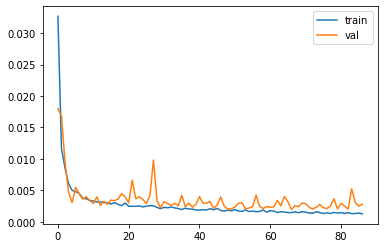

---Training time: 557.40986061 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98328, Train (V) - 0.84629
R2 scores: Validation (SS) - 0.96993, Validation (V) - 0.91204
R2 scores: Testing (SS) - 0.92135, Testing (V) - 0.87956
RMSE scores: Train (SS) - 0.02216, Train (V) - 0.03817
RMSE scores: Validation (SS) - 0.03408, Validation (V) - 0.03589
RMSE scores: Testing (SS) - 0.05400, Testing (V) - 0.04080


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

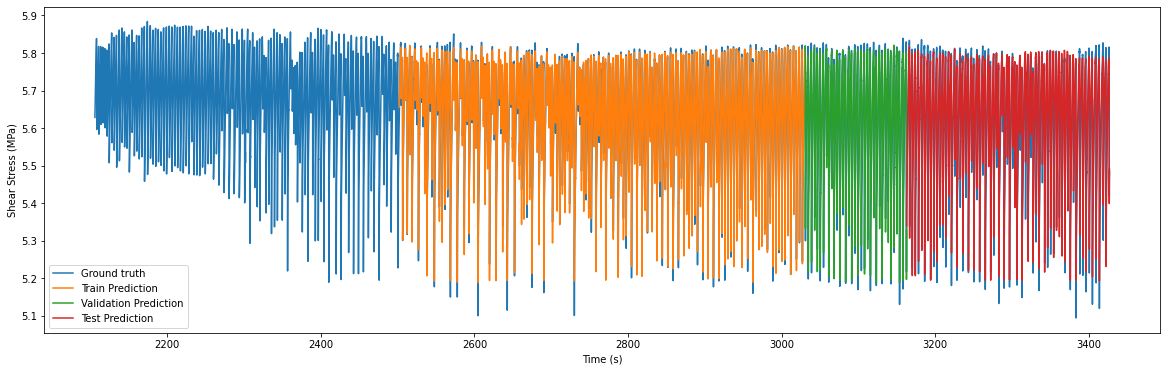

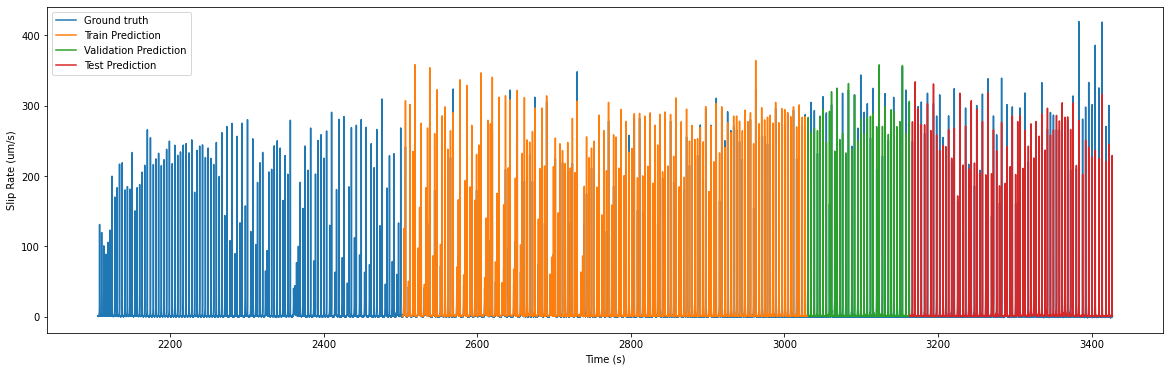

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[39629:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

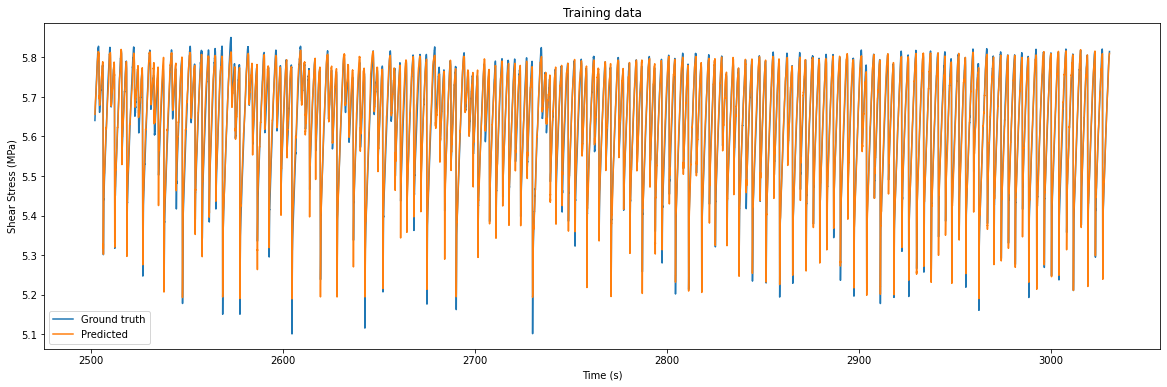

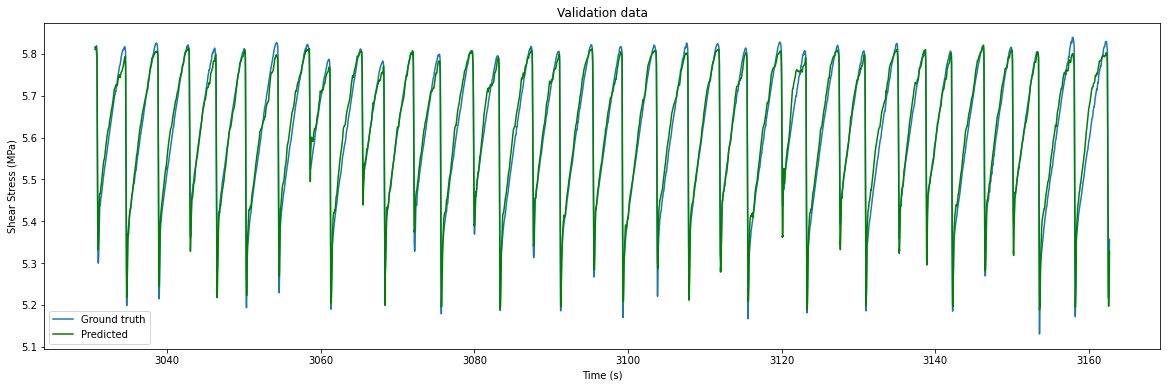

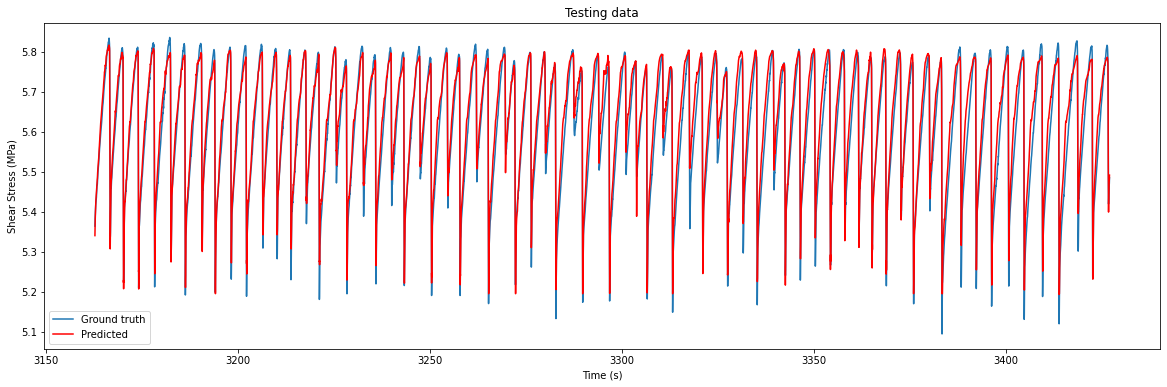

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

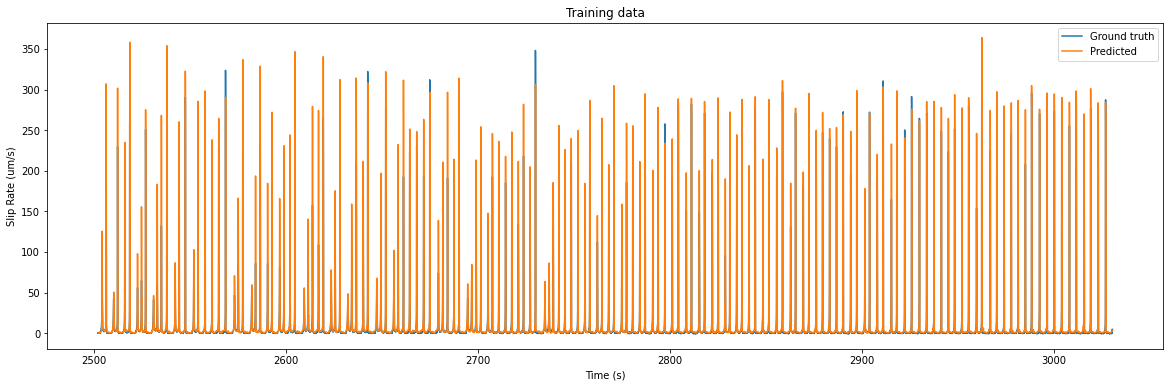

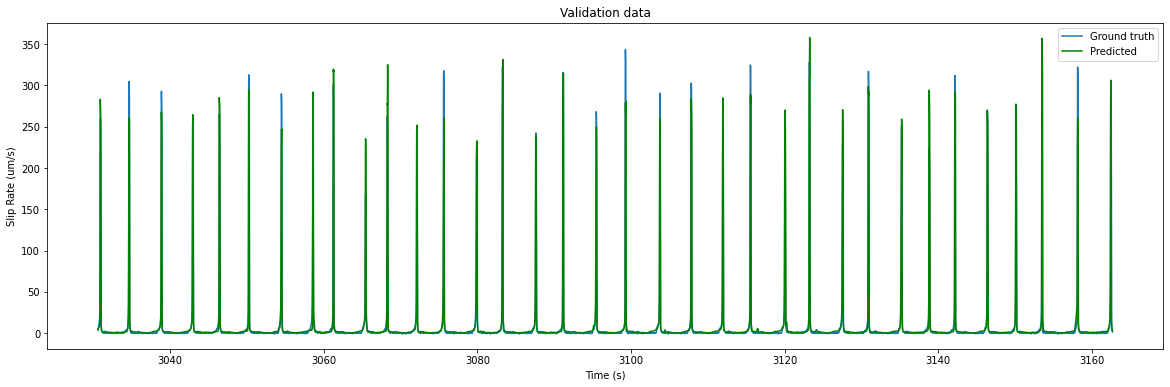

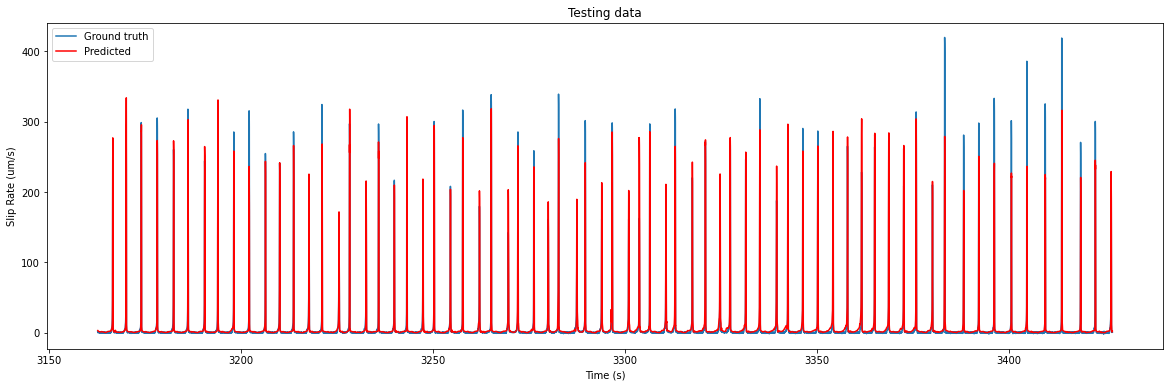

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')